# Stock predictor

We will predict stock's closing prices using LSTM(single feature)

In [262]:
!pip install pandas-datareader
!pip install tiingo


## API data fetch

In [263]:
import pandas_datareader as pdr
key="Enter your API-KEY"

# comapny stock ticker symbol
stock_tick='AAPL'
df = pdr.get_data_tiingo(stock_tick, api_key=key)

C:\Users\nachi\AppData\Local\Temp\ipykernel_4576\1737001057.py:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pdr.get_data_tiingo(stock_tick, api_key=key)


## Data visualisation

In [264]:
import pandas as pd

# create csv to avoid API fetches(50/day for tiingo)
df.to_csv(f'{stock_tick}.csv')
df=pd.read_csv(f'{stock_tick}.csv')
df.head()
# df.tail()
# df.__len__()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2018-09-24 00:00:00+00:00,220.79,221.26,216.63,216.82,27693358,52.860624,52.973150,51.864654,51.910143,110773432,0.0,1.0
1,AAPL,2018-09-25 00:00:00+00:00,222.19,222.82,219.70,219.75,24554379,53.195807,53.346639,52.599661,52.611632,98217516,0.0,1.0
2,AAPL,2018-09-26 00:00:00+00:00,220.42,223.75,219.76,221.00,23984706,52.772040,53.569295,52.614026,52.910902,95938824,0.0,1.0
3,AAPL,2018-09-27 00:00:00+00:00,224.95,226.44,223.54,223.82,30181227,53.856594,54.213324,53.519018,53.586054,120724908,0.0,1.0
4,AAPL,2018-09-28 00:00:00+00:00,225.74,225.84,224.02,224.79,22929364,54.045733,54.069674,53.633938,53.818288,91717456,0.0,1.0


In [265]:
# choosing a single feature 
df1=df.reset_index()['close']
df1

0       220.79
1       222.19
2       220.42
3       224.95
4       225.74
         ...  
1253    177.97
1254    179.07
1255    175.49
1256    173.93
1257    174.79
Name: close, Length: 1258, dtype: float64

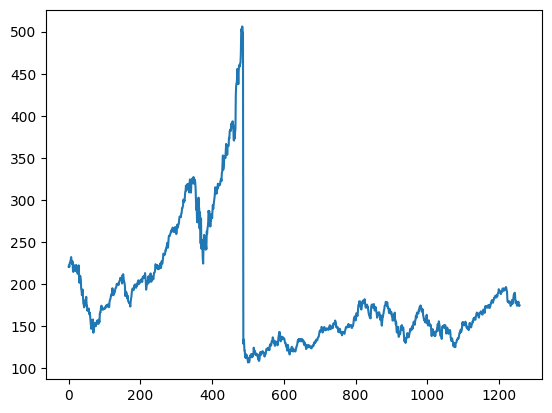

In [266]:
import matplotlib.pyplot as plt
plt.plot(df1)

## Preprocessing

In [267]:
# LSTM are sensitive to the scale of the data. So we apply MinMax scaler 

import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [268]:
# Thus every value is between -1 and 1
print(df1)
# len(df1)

[[0.28541014]
 [0.28891672]
 [0.28448341]
 ...
 [0.1719474 ]
 [0.16804008]
 [0.17019411]]


In [269]:
# Splitting dataset into train and test split (here train ==> 65%)

training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
training_size,test_size

(817, 441)

In [270]:
train_data

array([[2.85410144e-01],
       [2.88916719e-01],
       [2.84483406e-01],
       [2.95829681e-01],
       [2.97808391e-01],
       [3.01615529e-01],
       [3.06675016e-01],
       [3.13663118e-01],
       [3.03443957e-01],
       [2.94176581e-01],
       [2.92874139e-01],
       [3.00638698e-01],
       [2.74314339e-01],
       [2.69530369e-01],
       [2.88716343e-01],
       [2.76819036e-01],
       [2.88816531e-01],
       [2.86412023e-01],
       [2.73462743e-01],
       [2.81703193e-01],
       [2.85059487e-01],
       [2.90269255e-01],
       [2.71133375e-01],
       [2.82930495e-01],
       [2.74164058e-01],
       [2.63994991e-01],
       [2.66649969e-01],
       [2.80576080e-01],
       [2.88991860e-01],
       [2.52072636e-01],
       [2.37319975e-01],
       [2.42780213e-01],
       [2.58259236e-01],
       [2.54602379e-01],
       [2.44533500e-01],
       [2.18735128e-01],
       [2.13876018e-01],
       [2.00275517e-01],
       [2.11822167e-01],
       [2.17132123e-01],


In [271]:
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):

		# i=0, 0,1,2,3-----99   100
		a = dataset[i:(i+time_step), 0]    
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [272]:
# timeseries
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
# time_step are the no of previous features use to predict y 
# eg. ts=3 ,x train (100 110 145) , y train 160

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [273]:
print(X_train.shape)
print(y_train.shape)


(716, 100)
(716,)


In [274]:
print(X_test.shape)
print(ytest.shape)

(340, 100)
(340,)


In [275]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

## Creating the Model

In [276]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [277]:

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [278]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_13 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [280]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 19s 444ms/step - loss: 0.0323 - val_loss: 7.5124e-04
Epoch 2/100
12/12 [==============================] - 2s 209ms/step - loss: 0.0119 - val_loss: 0.0012
Epoch 3/100
12/12 [==============================] - 2s 191ms/step - loss: 0.0099 - val_loss: 4.2086e-04
Epoch 4/100
12/12 [==============================] - 2s 194ms/step - loss: 0.0080 - val_loss: 4.3363e-04
Epoch 5/100
12/12 [==============================] - 2s 193ms/step - loss: 0.0079 - val_loss: 6.2211e-04
Epoch 6/100
12/12 [==============================] - 3s 222ms/step - loss: 0.0063 - val_loss: 4.5665e-04
Epoch 7/100
12/12 [==============================] - 3s 218ms/step - loss: 0.0057 - val_loss: 3.1318e-04
Epoch 8/100
12/12 [==============================] - 3s 233ms/step - loss: 0.0049 - val_loss: 5.6771e-04
Epoch 9/100
12/12 [==============================] - 2s 200ms/step - loss: 0.0046 - val_loss: 3.9835e-04
Epoch 10/100
12/12 [==============================] - 2s 1

## Prediction and performance evaluation

In [281]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 1s 120ms/step


In [282]:
##Transform back to original form (we used MinMax scaler)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [283]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

219.24722625827349

In [284]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

159.093991892227

## Plotting 

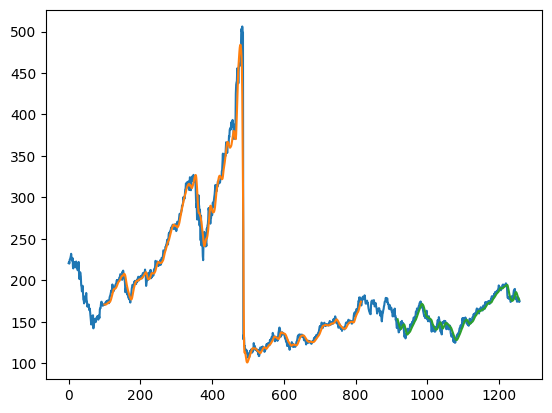

In [285]:
# Shift train predictions for plotting

look_back=100 # as time step =100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Predict future days

In [286]:
# previous days data to train from
pre_days = 100

# next days to predict
post_days =30

In [287]:
x_input=test_data[len(test_data)-pre_days:].reshape(1,-1)
x_input.shape

(1, 100)

In [288]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.1545397620538509,
 0.15180964308077638,
 0.1476518472135253,
 0.16713838447088286,
 0.16696305572949277,
 0.16262993112085156,
 0.16710081402629928,
 0.16758922980588598,
 0.16463368816530988,
 0.1633813400125234,
 0.1633813400125234,
 0.16493425172197868,
 0.17084533500313087,
 0.17112085159674384,
 0.1687163431433938,
 0.16210394489668123,
 0.16280525986224165,
 0.1656856606136506,
 0.17179711959924854,
 0.17648090169067,
 0.17635566687539134,
 0.1834690043832185,
 0.1856230432060112,
 0.18219160926737632,
 0.18126487163431432,
 0.1777833437695679,
 0.18467125860989347,
 0.18564809016906697,
 0.19273638071383836,
 0.1915341264871634,
 0.19313713212273004,
 0.19829680651221032,
 0.1955666875391358,
 0.1957921102066374,
 0.1931621790857858,
 0.2007764558547276,
 0.19997495303694424,
 0.19644333124608637,
 0.2034314339386349,
 0.2064120225422667,
 0.2072636192861615,
 0.21823418910457104,
 0.21445209768315587,
 0.21162179085785848,
 0.21282404508453345,
 0.20999373825923606,
 0.20480

In [289]:
# Demonstrate prediction for next n days
from numpy import array

lst_output=[]
n_steps=pre_days
i=0
while(i<post_days):
    

    if(len(temp_input)>pre_days):
        #print(temp_input)
        # Shifting one position to right for next training data set
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1

    # for 1st step make pre_day to preday+1 inputs eg(100==>101)
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.17162114]
101
1 day input [0.15180964 0.14765185 0.16713838 0.16696306 0.16262993 0.16710081
 0.16758923 0.16463369 0.16338134 0.16338134 0.16493425 0.17084534
 0.17112085 0.16871634 0.16210394 0.16280526 0.16568566 0.17179712
 0.1764809  0.17635567 0.183469   0.18562304 0.18219161 0.18126487
 0.17778334 0.18467126 0.18564809 0.19273638 0.19153413 0.19313713
 0.19829681 0.19556669 0.19579211 0.19316218 0.20077646 0.19997495
 0.19644333 0.20343143 0.20641202 0.20726362 0.21823419 0.2144521
 0.21162179 0.21282405 0.20999374 0.20480902 0.20348153 0.20771446
 0.20964308 0.21001879 0.21828428 0.21763306 0.2210645  0.21613024
 0.21314966 0.21517846 0.21735755 0.21956168 0.21635567 0.22289292
 0.22444584 0.22232937 0.21475266 0.21122104 0.18822793 0.18036318
 0.18274264 0.17871008 0.17815905 0.1777082  0.18189105 0.17685661
 0.17465247 0.1682154  0.16944271 0.17282405 0.17630557 0.18604884
 0.17417658 0.17976205 0.18371947 0.19356293 0.20240451 0.20295554
 0.20693801 0.20753914 0.19053225 

In [290]:
day_new=np.arange(1,1+pre_days)
day_pred=np.arange(1+pre_days,1+pre_days+post_days)
len(df1)
# lst_output.__len__()
# 1258-150

1258

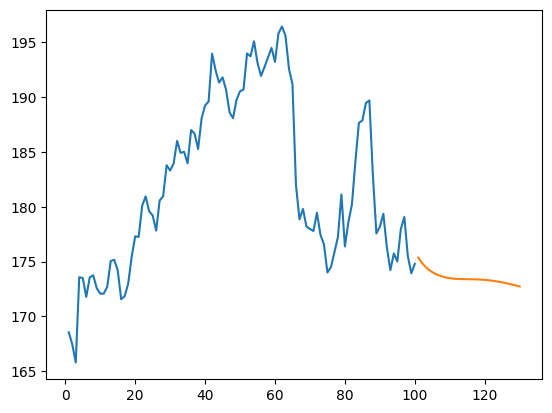

In [291]:
import matplotlib.pyplot as plt
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-pre_days:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

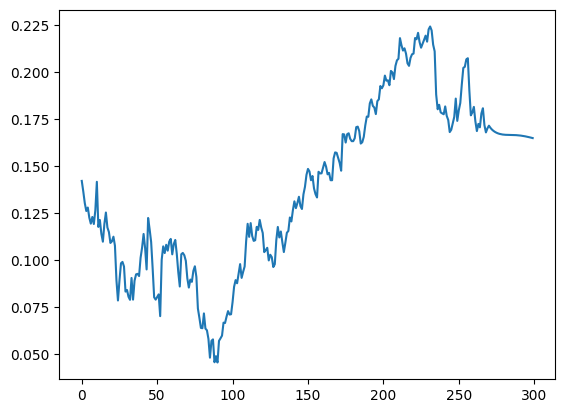

In [292]:
df3=df1.tolist()
df3.extend(lst_output)
# print(len(df3))
# to check the last x days
plt.plot(df3[-300:])

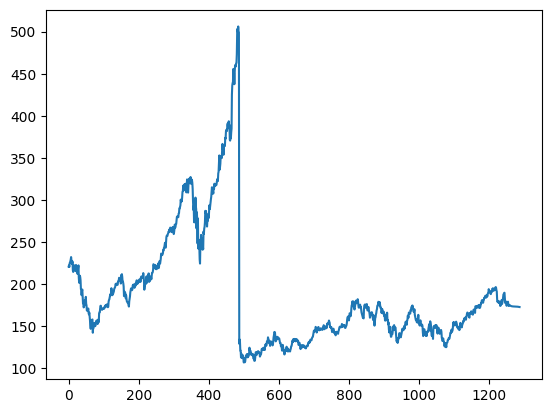

In [293]:
# to plot actual values
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)
# plt.plot(df3[-100:])